<a href="https://colab.research.google.com/github/taylsonmartinez/main_portfolio/blob/master/backtest/IFR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 25.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
df = yf.download("LREN3.SA", start="2015-01-01", end="2020-12-30").copy()[["Open", "High", "Close", "Adj Close"]]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Close,Adj Close
Date,,,,
2015-01-02,12.398653,12.475725,12.446208,11.124404
2015-01-05,12.369137,12.369137,12.100207,10.815151
2015-01-06,12.052652,12.359298,12.239591,10.939728
2015-01-07,12.278947,12.560995,12.447848,11.125873
2015-01-08,12.397013,12.544597,12.462606,11.139060


In [3]:
def rsi(data, column, window=2):   
    
    data = data.copy()
    
    # Establish gains and losses for each day
    data["Variation"] = data[column].diff()
    data = data[1:]
    data["Gain"] = np.where(data["Variation"] > 0, data["Variation"], 0)
    data["Loss"] = np.where(data["Variation"] < 0, data["Variation"], 0)

    # Calculate simple averages so we can initialize the classic averages
    simple_avg_gain = data["Gain"].rolling(window).mean()
    simple_avg_loss = data["Loss"].abs().rolling(window).mean()
    classic_avg_gain = simple_avg_gain.copy()
    classic_avg_loss = simple_avg_loss.copy()

    for i in range(window, len(classic_avg_gain)):
        classic_avg_gain[i] = (classic_avg_gain[i - 1] * (window - 1) + data["Gain"].iloc[i]) / window
        classic_avg_loss[i] = (classic_avg_loss[i - 1] * (window - 1) + data["Loss"].abs().iloc[i]) / window
    
    # Calculate the RSI
    RS = classic_avg_gain / classic_avg_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

In [4]:
df["IFR2"] = rsi(df, column="Adj Close")
df.head()

,Open,High,Close,Adj Close,IFR2
Date,,,,,
2015-01-02,12.398653,12.475725,12.446208,11.124404,NaN
2015-01-05,12.369137,12.369137,12.100207,10.815151,NaN
2015-01-06,12.052652,12.359298,12.239591,10.939728,28.715572
2015-01-07,12.278947,12.560995,12.447848,11.125873,61.636836
2015-01-08,12.397013,12.544597,12.462606,11.139060,63.993009


In [5]:
df["Target1"] = df["High"].shift(1)
df["Target2"] = df["High"].shift(2)
df["Target"] = df[["Target1", "Target2"]].max(axis=1)

# We don't need them anymore
df.drop(columns=["Target1", "Target2"], inplace=True)

df.head()

,Open,High,Close,Adj Close,IFR2,Target
Date,,,,,,
2015-01-02,12.398653,12.475725,12.446208,11.124404,NaN,NaN
2015-01-05,12.369137,12.369137,12.100207,10.815151,NaN,12.475725
2015-01-06,12.052652,12.359298,12.239591,10.939728,28.715572,12.475725
2015-01-07,12.278947,12.560995,12.447848,11.125873,61.636836,12.369137
2015-01-08,12.397013,12.544597,12.462606,11.139060,63.993009,12.560995


In [6]:
# Define exact buy price
rsi_parameter = 30
df["Buy Price"] = np.where(df["IFR2"] <= rsi_parameter, df["Close"], np.nan)

# Define exact sell price
df["Sell Price"] = np.where(
    df["High"] > df['Target'], 
    np.where(df['Open'] > df['Target'], df['Open'], df['Target']),
    np.nan)

df.head()

,Open,High,Close,Adj Close,IFR2,Target,Buy Price,Sell Price
Date,,,,,,,,
2015-01-02,12.398653,12.475725,12.446208,11.124404,NaN,NaN,NaN,NaN
2015-01-05,12.369137,12.369137,12.100207,10.815151,NaN,12.475725,NaN,NaN
2015-01-06,12.052652,12.359298,12.239591,10.939728,28.715572,12.475725,12.239591,NaN
2015-01-07,12.278947,12.560995,12.447848,11.125873,61.636836,12.369137,NaN,12.369137
2015-01-08,12.397013,12.544597,12.462606,11.139060,63.993009,12.560995,NaN,NaN


In [7]:
import math

# Create a function to round any number to the smalles multiple of 100
def round_down(x):
  return int(math.floor(x / 100.0)) * 100

# Define backtest parameters
initial_capital = 10000

total_capital = [initial_capital] # list with the total capital after every operation
all_profits = [] # list with profits for every operation
ongoing = False 

for i in range(0,len(df)):
    if ongoing == True:

        if ~(np.isnan(df['Sell Price'][i])):

            # Define exit point and total profit
            exit = df['Sell Price'][i]
            profit = shares * (exit - entry)

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1] # current capital is the last entry in the list
            total_capital += [current_capital + profit]
            ongoing = False
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            shares = round_down(initial_capital / entry)
            ongoing = True

In [8]:
def strategy_test(all_profits):
    num_operations = len(all_profits)
    gains = sum(x >= 0 for x in all_profits)
    pct_gains = 100 * (gains / num_operations)
    losses = num_operations - gains
    pct_losses = 100 - pct_gains

    print("Number of operations =", num_operations)
    print("Number of gains =", gains, "or", pct_gains.round(), "%")
    print("Number of loss =", losses, "or", pct_losses.round(), "%")
    print("The total profit was =", sum(all_profits))

strategy_test(all_profits)

Number of operations = 162
Number of gains = 118 or 73.0 %
Number of loss = 44 or 27.0 %
The total profit was = 14034.657955169678


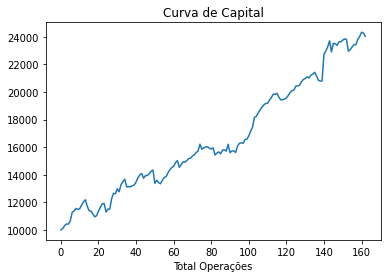

In [9]:
def capital_plot(total_capital, all_profits):
    all_profits = [0] + all_profits # make sure both lists are the same size
    cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
    plt.title("Curva de Capital")
    plt.xlabel("Total Operações")
    cap_evolution['Capital'].plot()

capital_plot(total_capital, all_profits)

In [10]:
days_in_operation = 0
gains_total_days = 0
gains_total_operations = 0
losses_total_days = 0
losses_total_operations = 0

ongoing = False

for i in range(0,len(df)):
    if ongoing == True:
        days_in_operation += 1
        if ~(np.isnan(df['Sell Price'][i])):
            exit = df['Sell Price'][i]
            is_positive = exit > entry
            ongoing = False
            
            # If profit is positive we increment the gains' variables
            # Else, we increment the losses' variables
            if is_positive > 0: 
                gains_total_days += days_in_operation
                gains_total_operations += 1
            else: 
                losses_total_days += days_in_operation
                losses_total_operations += 1
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            ongoing = True
            
            # Operation has started, initialize count of days until it ends
            days_in_operation = 0
            
# Define total number of days and the total number of operations during the period
total_days = gains_total_days + losses_total_days
total_operations = gains_total_operations + losses_total_operations

print("Average length of operations (in days)", total_days / total_operations)
print("Average length of gains (in days)", gains_total_days / gains_total_operations)
print("Average length of losses (in days)", losses_total_days / losses_total_operations)

Average length of operations (in days) 3.753086419753086
Average length of gains (in days) 2.8983050847457625
Average length of losses (in days) 6.045454545454546


In [11]:
# Define backtest parameters
initial_capital = 10000
max_days = 3 # add stop in time

# Control variables
total_capital = [initial_capital] # list with the total capital after every operation
all_profits = [] # list with profits for every operation
days_in_operation = 0
gains_total_days = 0
gains_total_operations = 0
losses_total_days = 0
losses_total_operations = 0
ongoing = False 

for i in range(0,len(df)):
    if ongoing == True:
        days_in_operation += 1

        # If any of the following conditions are met, the operation will end
        if days_in_operation == max_days or ~(np.isnan(df['Sell Price'][i])):

            # Define exit point and total profit
            exit = np.where(
                ~(np.isnan(df['Sell Price'][i])), 
                df['Sell Price'][i], 
                df['Close'][i])
            profit = shares * (exit - entry)

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1]
            total_capital += [current_capital + profit]

            # If profit is positive we increment the gains' variables
            # Else, we increment the losses' variables
            if profit > 0:
                gains_total_days += days_in_operation
                gains_total_operations += 1
            else: 
                losses_total_days += days_in_operation
                losses_total_operations += 1
            
            ongoing = False
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            shares = round_down(initial_capital / entry)
            days_in_operation = 0
            ongoing = True

# Define total number of days and the total number of operations during the period
total_days = gains_total_days + losses_total_days
total_operations = gains_total_operations + losses_total_operations

print("Average length of operations (in days)", total_days / total_operations)
print("Average length of gains (in days)", gains_total_days / gains_total_operations)
print("Average length of losses (in days)", losses_total_days / losses_total_operations)

Average length of operations (in days) 2.5380710659898478
Average length of gains (in days) 2.2540983606557377
Average length of losses (in days) 3.0


Number of operations = 197
Number of gains = 122 or 62.0 %
Number of loss = 75 or 38.0 %
The total profit was = 11924.990367889404


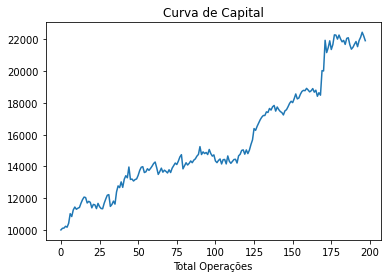

In [12]:
strategy_test(all_profits)
capital_plot(total_capital, all_profits)